In [1]:
from torch.utils.data import Dataset, DataLoader

In [2]:
#####
# Document Sentiment Prosa
#####
class DocumentSentimentDataset(Dataset):
    # Static constant variable
    LABEL2INDEX = {'negatif': 0, 'netral': 1,'positif': 2}
    INDEX2LABEL = {0: 'negatif', 1: 'netral', 2: 'positif'}
    NUM_LABELS = 3
    
    def load_dataset(self, path): 
        df = pd.read_csv(path)
        df = df[['text_cleaning','sentimen']]
        df.columns = ['text_cleaning','sentimen']
        #df['sentiment'] = df['sentiment'].apply(lambda lab: self.LABEL2INDEX[lab])
        return df
    
    def __init__(self, dataset_path, tokenizer, no_special_token=False, *args, **kwargs):
        self.data = self.load_dataset(dataset_path)
        self.tokenizer = tokenizer
        self.no_special_token = no_special_token
    
    def __getitem__(self, index):
        data = self.data.loc[index,:]
        text, sentiment = data['text_cleaning'], data['sentimen']
        subwords = self.tokenizer.encode(text, add_special_tokens=not self.no_special_token)
        return np.array(subwords), np.array(sentiment), data['text_cleaning']
    
    def __len__(self):
        return len(self.data)    
        
class DocumentSentimentDataLoader(DataLoader):
    def __init__(self, max_seq_len=512, *args, **kwargs):
        super(DocumentSentimentDataLoader, self).__init__(*args, **kwargs)
        self.collate_fn = self._collate_fn
        self.max_seq_len = max_seq_len
        
    def _collate_fn(self, batch):
        batch_size = len(batch)
        max_seq_len = max(map(lambda x: len(x[0]), batch))
        max_seq_len = min(self.max_seq_len, max_seq_len)
        
        subword_batch = np.zeros((batch_size, max_seq_len), dtype=np.int64)
        mask_batch = np.zeros((batch_size, max_seq_len), dtype=np.float32)
        sentiment_batch = np.zeros((batch_size, 1), dtype=np.int64)
        
        seq_list = []
        for i, (subwords, sentiment, raw_seq) in enumerate(batch):
            subwords = subwords[:max_seq_len]
            subword_batch[i,:len(subwords)] = subwords
            mask_batch[i,:len(subwords)] = 1
            sentiment_batch[i,0] = sentiment
            
            seq_list.append(raw_seq)
            
        return subword_batch, mask_batch, sentiment_batch, seq_list


In [3]:
# Forward function for sequence classification
def forward_sequence_classification(model, batch_data, i2w, is_test=False, device='cpu', **kwargs):
    # Unpack batch data
    if len(batch_data) == 3:
        (subword_batch, mask_batch, label_batch) = batch_data
        token_type_batch = None
    elif len(batch_data) == 4:
        (subword_batch, mask_batch, token_type_batch, label_batch) = batch_data
    
    # Prepare input & label
    subword_batch = torch.LongTensor(subword_batch)
    mask_batch = torch.FloatTensor(mask_batch)
    token_type_batch = torch.LongTensor(token_type_batch) if token_type_batch is not None else None
    label_batch = torch.LongTensor(label_batch)
            
    if device == "cuda":
        subword_batch = subword_batch.cuda()
        mask_batch = mask_batch.cuda()
        token_type_batch = token_type_batch.cuda() if token_type_batch is not None else None
        label_batch = label_batch.cuda()

    # Forward model
    outputs = model(subword_batch, attention_mask=mask_batch, token_type_ids=token_type_batch, labels=label_batch)
    loss, logits = outputs[:2]
    
    # generate prediction & label list
    list_hyp = []
    list_label = []
    hyp = torch.topk(logits, 1)[1]
    for j in range(len(hyp)):
        list_hyp.append(i2w[hyp[j].item()])
        list_label.append(i2w[label_batch[j][0].item()])
        
    return loss, list_hyp, list_label

def document_sentiment_metrics_fn(list_hyp, list_label):
    metrics = {}
    metrics["ACC"] = accuracy_score(list_label, list_hyp)
    metrics["F1"] = f1_score(list_label, list_hyp, average='macro')
    metrics["REC"] = recall_score(list_label, list_hyp, average='macro')
    metrics["PRE"] = precision_score(list_label, list_hyp, average='macro')
    return metrics

In [4]:
#!/usr/bin/env python

# Python version of the evaluation script from CoNLL'00-

# Intentional differences:
# - accept any space as delimiter by default
# - optional file argument (default STDIN)
# - option to set boundary (-b argument)
# - LaTeX output (-l argument) not supported
# - raw tags (-r argument) not supported

import sys
import re
from collections import defaultdict, namedtuple

Metrics = namedtuple('Metrics', 'tp fp fn prec rec fscore')

class EvalCounts(object):
    def __init__(self):
        self.correct_chunk = 0    # number of correctly identified chunks
        self.correct_tags = 0     # number of correct chunk tags
        self.found_correct = 0    # number of chunks in corpus
        self.found_guessed = 0    # number of identified chunks
        self.token_counter = 0    # token counter (ignores sentence breaks)

        # counts by type
        self.t_correct_chunk = defaultdict(int)
        self.t_found_correct = defaultdict(int)
        self.t_found_guessed = defaultdict(int)

###
# Evaluate Function
###        
def parse_tag(t):
    m = re.match(r'^([^-]*)-(.*)$', t)
    return m.groups() if m else (t, '')

def start_of_chunk(prev_tag, tag, prev_type, type_):
    # check if a chunk started between the previous and current word
    # arguments: previous and current chunk tags, previous and current types
    chunk_start = False

    if tag == 'B': chunk_start = True
    if tag == 'S': chunk_start = True

    if prev_tag == 'E' and tag == 'E': chunk_start = True
    if prev_tag == 'E' and tag == 'I': chunk_start = True
    if prev_tag == 'S' and tag == 'E': chunk_start = True
    if prev_tag == 'S' and tag == 'I': chunk_start = True
    if prev_tag == 'O' and tag == 'E': chunk_start = True
    if prev_tag == 'O' and tag == 'I': chunk_start = True

    if tag != 'O' and tag != '.' and prev_type != type_:
        chunk_start = True

    # these chunks are assumed to have length 1
    if tag == '[': chunk_start = True
    if tag == ']': chunk_start = True

    return chunk_start

def end_of_chunk(prev_tag, tag, prev_type, type_):
    # check if a chunk ended between the previous and current word
    # arguments: previous and current chunk tags, previous and current types
    chunk_end = False

    if prev_tag == 'E': chunk_end = True
    if prev_tag == 'S': chunk_end = True

    if prev_tag == 'B' and tag == 'B': chunk_end = True
    if prev_tag == 'B' and tag == 'S': chunk_end = True
    if prev_tag == 'B' and tag == 'O': chunk_end = True
    if prev_tag == 'I' and tag == 'B': chunk_end = True
    if prev_tag == 'I' and tag == 'S': chunk_end = True
    if prev_tag == 'I' and tag == 'O': chunk_end = True

    if prev_tag != 'O' and prev_tag != '.' and prev_type != type_:
        chunk_end = True

    # these chunks are assumed to have length 1
    if prev_tag == ']': chunk_end = True
    if prev_tag == '[': chunk_end = True

    return chunk_end

def evaluate_fn(guessed, correct, last_correct, last_correct_type, last_guessed, last_guessed_type, in_correct, counts):
    guessed, guessed_type = parse_tag(guessed)
    correct, correct_type = parse_tag(correct)

    end_correct = end_of_chunk(last_correct, correct,
                               last_correct_type, correct_type)
    end_guessed = end_of_chunk(last_guessed, guessed,
                               last_guessed_type, guessed_type)
    start_correct = start_of_chunk(last_correct, correct,
                                   last_correct_type, correct_type)
    start_guessed = start_of_chunk(last_guessed, guessed,
                                   last_guessed_type, guessed_type)

    if in_correct:
        if (end_correct and end_guessed and
            last_guessed_type == last_correct_type):
            in_correct = False
            counts.correct_chunk += 1
            counts.t_correct_chunk[last_correct_type] += 1
        elif (end_correct != end_guessed or guessed_type != correct_type):
            in_correct = False

    if start_correct and start_guessed and guessed_type == correct_type:
        in_correct = True

    if start_correct:
        counts.found_correct += 1
        counts.t_found_correct[correct_type] += 1
    if start_guessed:
        counts.found_guessed += 1
        counts.t_found_guessed[guessed_type] += 1
    if correct == guessed and guessed_type == correct_type:
        counts.correct_tags += 1
    counts.token_counter += 1

    last_guessed = guessed
    last_correct = correct
    last_guessed_type = guessed_type
    last_correct_type = correct_type
    
    return last_correct, last_correct_type, last_guessed, last_guessed_type, in_correct, counts
    
def evaluate(hyps_list, labels_list):
    counts = EvalCounts()
    num_features = None       # number of features per line
    in_correct = False        # currently processed chunks is correct until now
    last_correct = 'O'        # previous chunk tag in corpus
    last_correct_type = ''    # type of previously identified chunk tag
    last_guessed = 'O'        # previously identified chunk tag
    last_guessed_type = ''    # type of previous chunk tag in corpus

    for hyps, labels in zip(hyps_list, labels_list):
        for hyp, label in zip(hyps, labels):
            step_result = evaluate_fn(hyp, label, last_correct, last_correct_type, last_guessed, last_guessed_type, in_correct, counts)
            last_correct, last_correct_type, last_guessed, last_guessed_type, in_correct, counts = step_result
        # Boundary between sentence
        step_result = evaluate_fn('O', 'O', last_correct, last_correct_type, last_guessed, last_guessed_type, in_correct, counts)
        last_correct, last_correct_type, last_guessed, last_guessed_type, in_correct, counts = step_result
        
    if in_correct:
        counts.correct_chunk += 1
        counts.t_correct_chunk[last_correct_type] += 1

    return counts

###
# Calculate Metrics Function
###
def uniq(iterable):
    seen = set()
    return [i for i in iterable if not (i in seen or seen.add(i))]

def calculate_metrics(correct, guessed, total):
    tp, fp, fn = correct, guessed-correct, total-correct
    p = 0 if tp + fp == 0 else 1.*tp / (tp + fp)
    r = 0 if tp + fn == 0 else 1.*tp / (tp + fn)
    f = 0 if p + r == 0 else (2 * p * r) / (p + r)
    return Metrics(tp, fp, fn, p, r, f)

def metrics(counts):
    c = counts
    overall = calculate_metrics(
        c.correct_chunk, c.found_guessed, c.found_correct
    )
    by_type = {}
    for t in uniq(list(c.t_found_correct.keys()) + list(c.t_found_guessed.keys())):
        by_type[t] = calculate_metrics(
            c.t_correct_chunk[t], c.t_found_guessed[t], c.t_found_correct[t]
        )
    return overall, by_type
    return overall

###
# Main Function
###
def conll_evaluation(hyps_list, labels_list):
    counts = evaluate(hyps_list, labels_list)
    overall, by_type = metrics(counts)

    c = counts
    acc = c.correct_tags / c.token_counter
    pre = overall.prec
    rec = overall.rec
    f1 = overall.fscore
    
    type_macro_pre = 0.0
    type_macro_rec = 0.0
    type_macro_f1 = 0.0
    for k in by_type.keys():
        type_macro_pre += by_type[k].prec
        type_macro_rec += by_type[k].rec
        type_macro_f1 += by_type[k].fscore
        
    type_macro_pre = type_macro_pre / float(len(by_type))
    type_macro_rec = type_macro_rec / float(len(by_type))
    type_macro_f1 = type_macro_f1 / float(len(by_type))
    
    return (acc, pre, rec, f1, type_macro_pre, type_macro_rec, type_macro_f1)


In [5]:
import random
import numpy as np
import pandas as pd
import torch
from torch import optim
import torch.nn.functional as F
from tqdm import tqdm

from transformers import BertForSequenceClassification, BertConfig, BertTokenizer
from nltk.tokenize import TweetTokenizer
import itertools
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

In [6]:
###
# common functions
###
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
def count_param(module, trainable=False):
    if trainable:
        return sum(p.numel() for p in module.parameters() if p.requires_grad)
    else:
        return sum(p.numel() for p in module.parameters())
    
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def metrics_to_string(metric_dict):
    string_list = []
    for key, value in metric_dict.items():
        string_list.append('{}:{:.2f}'.format(key, value))
    return ' '.join(string_list)

In [7]:
# Set random seed
set_seed(26092020)

In [ ]:
# Load Tokenizer and Config
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p2')
config = BertConfig.from_pretrained('indobenchmark/indobert-base-p2')
config.num_labels = DocumentSentimentDataset.NUM_LABELS

# Instantiate model
model = BertForSequenceClassification.from_pretrained('indobenchmark/indobert-base-p2', config=config)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
# import pandas as pd
# from sklearn.model_selection import train_test_split

# # Load dataset
# data = pd.read_csv('mobil_listrik.csv').dropna(subset=['text_cleaning'])
# data['sentimen'] = data['sentimen'].astype('category').cat.codes
# # Split dataset into train (80%) and temp (20%)
# train_data, temp_data = train_test_split(data, test_size=0.1, random_state=3)

# # Split temp into validation (50% of 20% = 10%) and test (50% of 20% = 10%)
# val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=3)

# # Save to CSV files
# train_data.to_csv('trainp2.csv', index=False)
# val_data.to_csv('valp2.csv', index=False)
# test_data.to_csv('testp2.csv', index=False)
# temp_data.to_csv('testnovalp2.csv',index=False)

# print("Dataset has been split and saved to train.csv, val.csv, and test.csv")

In [10]:
train_dataset = DocumentSentimentDataset('trainp2.csv', tokenizer, lowercase=True)
valid_dataset = DocumentSentimentDataset('testnovalp2.csv', tokenizer, lowercase=True)
test_dataset = DocumentSentimentDataset('testp2.csv', tokenizer, lowercase=True)

train_loader = DocumentSentimentDataLoader(dataset=train_dataset, max_seq_len=512, batch_size=10, num_workers=16, shuffle=True)  
valid_loader = DocumentSentimentDataLoader(dataset=valid_dataset, max_seq_len=512, batch_size=10, num_workers=16, shuffle=False)  
test_loader = DocumentSentimentDataLoader(dataset=test_dataset, max_seq_len=512, batch_size=10, num_workers=16, shuffle=False)

In [11]:
w2i, i2w = DocumentSentimentDataset.LABEL2INDEX, DocumentSentimentDataset.INDEX2LABEL
print(w2i)
print(i2w)

{'negatif': 0, 'netral': 1, 'positif': 2}
{0: 'negatif', 1: 'netral', 2: 'positif'}


In [12]:
text = 'Wacana itu bagus karena akan meminimalisir emisi gas karbon'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: Wacana itu bagus karena akan meminimalisir emisi gas karbon | Label : positif (37.844%)


In [13]:
# Inisialisasi model dan optimizer
model = model.cuda()
optimizer = optim.Adam(model.parameters(), lr=3e-5)

In [14]:
n_epochs = 50
# Initialize lists to store metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
best_val_accuracy = 0

for epoch in range(n_epochs):
    model.train()
    torch.set_grad_enabled(True)

    total_train_loss = 0
    list_hyp, list_label = [], []

    train_pbar = tqdm(train_loader, leave=True, total=len(train_loader))
    for i, batch_data in enumerate(train_pbar):
        # Forward model
        loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')

        # Update model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        tr_loss = loss.item()
        total_train_loss = total_train_loss + tr_loss

        # Calculate metrics
        list_hyp += batch_hyp
        list_label += batch_label

        train_pbar.set_description("(Epoch {}) TRAIN LOSS:{:.4f} LR:{:.8f}".format((epoch+1),
            total_train_loss/(i+1), get_lr(optimizer)))

    # Calculate train metric
    train_metrics = document_sentiment_metrics_fn(list_hyp, list_label)
    train_loss_avg = total_train_loss / len(train_loader)
    train_accuracy = train_metrics['ACC']  # Assuming the metrics dictionary has an 'accuracy' key

    train_losses.append(train_loss_avg)
    train_accuracies.append(train_accuracy)

    print("(Epoch {}) TRAIN LOSS:{:.4f} {} LR:{:.8f}".format((epoch+1),
        train_loss_avg, metrics_to_string(train_metrics), get_lr(optimizer)))

    # Evaluate on validation
    model.eval()
    torch.set_grad_enabled(False)

    total_loss = 0
    list_hyp, list_label = [], []

    pbar = tqdm(valid_loader, leave=True, total=len(valid_loader))
    for i, batch_data in enumerate(pbar):
        loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')
        
        # Calculate total loss
        valid_loss = loss.item()
        total_loss = total_loss + valid_loss

        # Calculate evaluation metrics
        list_hyp += batch_hyp
        list_label += batch_label

        pbar.set_description("VALID LOSS:{:.4f}".format(total_loss/(i+1)))

    val_metrics = document_sentiment_metrics_fn(list_hyp, list_label)
    val_loss_avg = total_loss / len(valid_loader)
    val_accuracy = val_metrics['ACC']  # Assuming the metrics dictionary has an 'accuracy' key

    val_losses.append(val_loss_avg)
    val_accuracies.append(val_accuracy)

    print("(Epoch {}) VALID LOSS:{:.4f} {}".format((epoch+1),
        val_loss_avg, metrics_to_string(val_metrics)))
    #Perbarui akurasi validasi tertinggi jika akurasi saat ini lebih tinggi
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        # Simpan model yang memiliki akurasi validasi tertinggi
        torch.save(model.state_dict(), 'Best_Model_IndoBERTBaseP2_Ep50.pth')
        print(f"New best validation accuracy: {best_val_accuracy:.4f} - model saved.")



(Epoch 1) TRAIN LOSS:0.8496 LR:0.00003000: 100%|██████████| 137/137 [00:30<00:00,  4.42it/s]


(Epoch 1) TRAIN LOSS:0.8496 ACC:0.61 F1:0.38 REC:0.40 PRE:0.39 LR:0.00003000


VALID LOSS:0.6978: 100%|██████████| 16/16 [00:01<00:00,  9.74it/s]
/home/anugerahsurya/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(Epoch 1) VALID LOSS:0.6978 ACC:0.68 F1:0.43 REC:0.45 PRE:0.47
New best validation accuracy: 0.6842 - model saved.


(Epoch 2) TRAIN LOSS:0.5855 LR:0.00003000: 100%|██████████| 137/137 [00:30<00:00,  4.44it/s]


(Epoch 2) TRAIN LOSS:0.5855 ACC:0.77 F1:0.64 REC:0.61 PRE:0.71 LR:0.00003000


VALID LOSS:0.7428: 100%|██████████| 16/16 [00:01<00:00, 10.39it/s]
/home/anugerahsurya/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(Epoch 2) VALID LOSS:0.7428 ACC:0.72 F1:0.49 REC:0.52 PRE:0.47
New best validation accuracy: 0.7237 - model saved.


(Epoch 3) TRAIN LOSS:0.3192 LR:0.00003000: 100%|██████████| 137/137 [00:32<00:00,  4.27it/s]


(Epoch 3) TRAIN LOSS:0.3192 ACC:0.88 F1:0.79 REC:0.77 PRE:0.82 LR:0.00003000


VALID LOSS:0.6920: 100%|██████████| 16/16 [00:01<00:00, 10.18it/s]


(Epoch 3) VALID LOSS:0.6920 ACC:0.72 F1:0.58 REC:0.57 PRE:0.63


(Epoch 4) TRAIN LOSS:0.2016 LR:0.00003000: 100%|██████████| 137/137 [00:31<00:00,  4.35it/s]


(Epoch 4) TRAIN LOSS:0.2016 ACC:0.93 F1:0.88 REC:0.87 PRE:0.89 LR:0.00003000


VALID LOSS:1.2066: 100%|██████████| 16/16 [00:01<00:00,  9.67it/s]


(Epoch 4) VALID LOSS:1.2066 ACC:0.69 F1:0.51 REC:0.50 PRE:0.56


(Epoch 5) TRAIN LOSS:0.0960 LR:0.00003000: 100%|██████████| 137/137 [00:31<00:00,  4.31it/s]


(Epoch 5) TRAIN LOSS:0.0960 ACC:0.97 F1:0.96 REC:0.96 PRE:0.96 LR:0.00003000


VALID LOSS:1.2583: 100%|██████████| 16/16 [00:01<00:00, 10.15it/s]


(Epoch 5) VALID LOSS:1.2583 ACC:0.72 F1:0.52 REC:0.52 PRE:0.54


(Epoch 6) TRAIN LOSS:0.0926 LR:0.00003000: 100%|██████████| 137/137 [00:32<00:00,  4.18it/s]


(Epoch 6) TRAIN LOSS:0.0926 ACC:0.97 F1:0.95 REC:0.95 PRE:0.96 LR:0.00003000


VALID LOSS:1.2457: 100%|██████████| 16/16 [00:01<00:00,  9.77it/s]


(Epoch 6) VALID LOSS:1.2457 ACC:0.68 F1:0.56 REC:0.57 PRE:0.58


(Epoch 7) TRAIN LOSS:0.0518 LR:0.00003000: 100%|██████████| 137/137 [00:32<00:00,  4.22it/s]


(Epoch 7) TRAIN LOSS:0.0518 ACC:0.98 F1:0.97 REC:0.97 PRE:0.98 LR:0.00003000


VALID LOSS:1.5175: 100%|██████████| 16/16 [00:01<00:00,  9.80it/s]


(Epoch 7) VALID LOSS:1.5175 ACC:0.73 F1:0.55 REC:0.54 PRE:0.60
New best validation accuracy: 0.7303 - model saved.


(Epoch 8) TRAIN LOSS:0.0423 LR:0.00003000: 100%|██████████| 137/137 [00:32<00:00,  4.22it/s]


(Epoch 8) TRAIN LOSS:0.0423 ACC:0.99 F1:0.97 REC:0.97 PRE:0.97 LR:0.00003000


VALID LOSS:1.4560: 100%|██████████| 16/16 [00:01<00:00,  9.47it/s]


(Epoch 8) VALID LOSS:1.4560 ACC:0.71 F1:0.56 REC:0.54 PRE:0.61


(Epoch 9) TRAIN LOSS:0.0331 LR:0.00003000: 100%|██████████| 137/137 [00:32<00:00,  4.21it/s]


(Epoch 9) TRAIN LOSS:0.0331 ACC:0.99 F1:0.99 REC:0.98 PRE:0.99 LR:0.00003000


VALID LOSS:1.4660: 100%|██████████| 16/16 [00:01<00:00,  9.99it/s]


(Epoch 9) VALID LOSS:1.4660 ACC:0.70 F1:0.57 REC:0.56 PRE:0.59


(Epoch 10) TRAIN LOSS:0.0269 LR:0.00003000: 100%|██████████| 137/137 [00:32<00:00,  4.16it/s]


(Epoch 10) TRAIN LOSS:0.0269 ACC:0.99 F1:0.99 REC:0.99 PRE:0.98 LR:0.00003000


VALID LOSS:1.6429: 100%|██████████| 16/16 [00:01<00:00,  9.69it/s]


(Epoch 10) VALID LOSS:1.6429 ACC:0.69 F1:0.51 REC:0.53 PRE:0.62


(Epoch 11) TRAIN LOSS:0.0635 LR:0.00003000: 100%|██████████| 137/137 [00:33<00:00,  4.05it/s]


(Epoch 11) TRAIN LOSS:0.0635 ACC:0.98 F1:0.97 REC:0.97 PRE:0.96 LR:0.00003000


VALID LOSS:1.4180: 100%|██████████| 16/16 [00:01<00:00,  9.22it/s]


(Epoch 11) VALID LOSS:1.4180 ACC:0.72 F1:0.58 REC:0.58 PRE:0.62


(Epoch 12) TRAIN LOSS:0.0242 LR:0.00003000: 100%|██████████| 137/137 [00:34<00:00,  3.95it/s]


(Epoch 12) TRAIN LOSS:0.0242 ACC:0.99 F1:0.99 REC:0.99 PRE:0.99 LR:0.00003000


VALID LOSS:1.6132: 100%|██████████| 16/16 [00:01<00:00,  9.06it/s]


(Epoch 12) VALID LOSS:1.6132 ACC:0.70 F1:0.54 REC:0.53 PRE:0.67


(Epoch 13) TRAIN LOSS:0.0152 LR:0.00003000: 100%|██████████| 137/137 [00:35<00:00,  3.87it/s]


(Epoch 13) TRAIN LOSS:0.0152 ACC:0.99 F1:0.99 REC:0.99 PRE:0.98 LR:0.00003000


VALID LOSS:1.7961: 100%|██████████| 16/16 [00:01<00:00,  9.21it/s]


(Epoch 13) VALID LOSS:1.7961 ACC:0.68 F1:0.54 REC:0.55 PRE:0.67


(Epoch 14) TRAIN LOSS:0.0197 LR:0.00003000: 100%|██████████| 137/137 [00:35<00:00,  3.84it/s]


(Epoch 14) TRAIN LOSS:0.0197 ACC:0.99 F1:0.99 REC:0.99 PRE:0.99 LR:0.00003000


VALID LOSS:1.8714: 100%|██████████| 16/16 [00:01<00:00,  9.13it/s]


(Epoch 14) VALID LOSS:1.8714 ACC:0.68 F1:0.51 REC:0.54 PRE:0.57


(Epoch 15) TRAIN LOSS:0.0677 LR:0.00003000: 100%|██████████| 137/137 [00:36<00:00,  3.80it/s]


(Epoch 15) TRAIN LOSS:0.0677 ACC:0.98 F1:0.98 REC:0.98 PRE:0.97 LR:0.00003000


VALID LOSS:1.4007: 100%|██████████| 16/16 [00:01<00:00,  9.61it/s]


(Epoch 15) VALID LOSS:1.4007 ACC:0.66 F1:0.53 REC:0.54 PRE:0.54


(Epoch 16) TRAIN LOSS:0.0207 LR:0.00003000: 100%|██████████| 137/137 [00:35<00:00,  3.81it/s]


(Epoch 16) TRAIN LOSS:0.0207 ACC:0.99 F1:0.99 REC:0.99 PRE:0.99 LR:0.00003000


VALID LOSS:1.2347: 100%|██████████| 16/16 [00:01<00:00,  8.75it/s]


(Epoch 16) VALID LOSS:1.2347 ACC:0.71 F1:0.55 REC:0.54 PRE:0.57


(Epoch 17) TRAIN LOSS:0.0351 LR:0.00003000: 100%|██████████| 137/137 [00:36<00:00,  3.74it/s]


(Epoch 17) TRAIN LOSS:0.0351 ACC:0.99 F1:0.98 REC:0.98 PRE:0.98 LR:0.00003000


VALID LOSS:1.3510: 100%|██████████| 16/16 [00:01<00:00,  9.00it/s]


(Epoch 17) VALID LOSS:1.3510 ACC:0.75 F1:0.57 REC:0.55 PRE:0.84
New best validation accuracy: 0.7500 - model saved.


(Epoch 18) TRAIN LOSS:0.0374 LR:0.00003000: 100%|██████████| 137/137 [00:36<00:00,  3.77it/s]


(Epoch 18) TRAIN LOSS:0.0374 ACC:0.99 F1:0.98 REC:0.98 PRE:0.99 LR:0.00003000


VALID LOSS:1.2529: 100%|██████████| 16/16 [00:01<00:00,  9.45it/s]


(Epoch 18) VALID LOSS:1.2529 ACC:0.73 F1:0.62 REC:0.60 PRE:0.65


(Epoch 19) TRAIN LOSS:0.0394 LR:0.00003000: 100%|██████████| 137/137 [00:37<00:00,  3.62it/s]


(Epoch 19) TRAIN LOSS:0.0394 ACC:0.99 F1:0.98 REC:0.98 PRE:0.98 LR:0.00003000


VALID LOSS:1.4462: 100%|██████████| 16/16 [00:01<00:00,  8.68it/s]


(Epoch 19) VALID LOSS:1.4462 ACC:0.70 F1:0.60 REC:0.60 PRE:0.62


(Epoch 20) TRAIN LOSS:0.0401 LR:0.00003000: 100%|██████████| 137/137 [00:37<00:00,  3.63it/s]


(Epoch 20) TRAIN LOSS:0.0401 ACC:0.99 F1:0.97 REC:0.97 PRE:0.98 LR:0.00003000


VALID LOSS:1.3927: 100%|██████████| 16/16 [00:01<00:00,  9.26it/s]


(Epoch 20) VALID LOSS:1.3927 ACC:0.70 F1:0.55 REC:0.54 PRE:0.55


(Epoch 21) TRAIN LOSS:0.0066 LR:0.00003000: 100%|██████████| 137/137 [00:38<00:00,  3.60it/s]


(Epoch 21) TRAIN LOSS:0.0066 ACC:1.00 F1:1.00 REC:1.00 PRE:1.00 LR:0.00003000


VALID LOSS:1.5258: 100%|██████████| 16/16 [00:01<00:00,  8.90it/s]


(Epoch 21) VALID LOSS:1.5258 ACC:0.71 F1:0.54 REC:0.53 PRE:0.55


(Epoch 22) TRAIN LOSS:0.0018 LR:0.00003000: 100%|██████████| 137/137 [00:38<00:00,  3.55it/s]


(Epoch 22) TRAIN LOSS:0.0018 ACC:1.00 F1:1.00 REC:1.00 PRE:1.00 LR:0.00003000


VALID LOSS:1.5950: 100%|██████████| 16/16 [00:01<00:00,  8.91it/s]


(Epoch 22) VALID LOSS:1.5950 ACC:0.72 F1:0.56 REC:0.55 PRE:0.57


(Epoch 23) TRAIN LOSS:0.0065 LR:0.00003000: 100%|██████████| 137/137 [00:36<00:00,  3.74it/s]


(Epoch 23) TRAIN LOSS:0.0065 ACC:1.00 F1:1.00 REC:1.00 PRE:1.00 LR:0.00003000


VALID LOSS:1.4966: 100%|██████████| 16/16 [00:01<00:00,  8.75it/s]


(Epoch 23) VALID LOSS:1.4966 ACC:0.70 F1:0.54 REC:0.54 PRE:0.55


(Epoch 24) TRAIN LOSS:0.0013 LR:0.00003000: 100%|██████████| 137/137 [00:39<00:00,  3.49it/s]


(Epoch 24) TRAIN LOSS:0.0013 ACC:1.00 F1:1.00 REC:1.00 PRE:1.00 LR:0.00003000


VALID LOSS:1.7152: 100%|██████████| 16/16 [00:01<00:00,  8.69it/s]


(Epoch 24) VALID LOSS:1.7152 ACC:0.73 F1:0.56 REC:0.55 PRE:0.60


(Epoch 25) TRAIN LOSS:0.0005 LR:0.00003000: 100%|██████████| 137/137 [00:38<00:00,  3.60it/s]


(Epoch 25) TRAIN LOSS:0.0005 ACC:1.00 F1:1.00 REC:1.00 PRE:1.00 LR:0.00003000


VALID LOSS:1.7542: 100%|██████████| 16/16 [00:01<00:00,  9.49it/s]


(Epoch 25) VALID LOSS:1.7542 ACC:0.70 F1:0.56 REC:0.56 PRE:0.57


(Epoch 26) TRAIN LOSS:0.0003 LR:0.00003000: 100%|██████████| 137/137 [00:38<00:00,  3.52it/s]


(Epoch 26) TRAIN LOSS:0.0003 ACC:1.00 F1:1.00 REC:1.00 PRE:1.00 LR:0.00003000


VALID LOSS:1.7730: 100%|██████████| 16/16 [00:01<00:00,  8.60it/s]


(Epoch 26) VALID LOSS:1.7730 ACC:0.72 F1:0.57 REC:0.57 PRE:0.59


(Epoch 27) TRAIN LOSS:0.0002 LR:0.00003000: 100%|██████████| 137/137 [00:39<00:00,  3.48it/s]


(Epoch 27) TRAIN LOSS:0.0002 ACC:1.00 F1:1.00 REC:1.00 PRE:1.00 LR:0.00003000


VALID LOSS:1.8006: 100%|██████████| 16/16 [00:01<00:00,  8.67it/s]


(Epoch 27) VALID LOSS:1.8006 ACC:0.72 F1:0.57 REC:0.57 PRE:0.59


(Epoch 28) TRAIN LOSS:0.0002 LR:0.00003000: 100%|██████████| 137/137 [00:38<00:00,  3.58it/s]


(Epoch 28) TRAIN LOSS:0.0002 ACC:1.00 F1:1.00 REC:1.00 PRE:1.00 LR:0.00003000


VALID LOSS:1.8196: 100%|██████████| 16/16 [00:01<00:00,  9.07it/s]


(Epoch 28) VALID LOSS:1.8196 ACC:0.72 F1:0.57 REC:0.57 PRE:0.60


(Epoch 29) TRAIN LOSS:0.0002 LR:0.00003000: 100%|██████████| 137/137 [00:38<00:00,  3.58it/s]


(Epoch 29) TRAIN LOSS:0.0002 ACC:1.00 F1:1.00 REC:1.00 PRE:1.00 LR:0.00003000


VALID LOSS:1.8368: 100%|██████████| 16/16 [00:01<00:00,  8.88it/s]


(Epoch 29) VALID LOSS:1.8368 ACC:0.72 F1:0.58 REC:0.57 PRE:0.61


(Epoch 30) TRAIN LOSS:0.0002 LR:0.00003000: 100%|██████████| 137/137 [00:39<00:00,  3.51it/s]


(Epoch 30) TRAIN LOSS:0.0002 ACC:1.00 F1:1.00 REC:1.00 PRE:1.00 LR:0.00003000


VALID LOSS:1.8652: 100%|██████████| 16/16 [00:01<00:00,  9.89it/s]


(Epoch 30) VALID LOSS:1.8652 ACC:0.72 F1:0.57 REC:0.57 PRE:0.60


(Epoch 31) TRAIN LOSS:0.0001 LR:0.00003000: 100%|██████████| 137/137 [00:39<00:00,  3.51it/s]


(Epoch 31) TRAIN LOSS:0.0001 ACC:1.00 F1:1.00 REC:1.00 PRE:1.00 LR:0.00003000


VALID LOSS:1.8843: 100%|██████████| 16/16 [00:01<00:00,  8.68it/s]


(Epoch 31) VALID LOSS:1.8843 ACC:0.72 F1:0.58 REC:0.57 PRE:0.61


(Epoch 32) TRAIN LOSS:0.0001 LR:0.00003000: 100%|██████████| 137/137 [00:38<00:00,  3.59it/s]


(Epoch 32) TRAIN LOSS:0.0001 ACC:1.00 F1:1.00 REC:1.00 PRE:1.00 LR:0.00003000


VALID LOSS:1.9038: 100%|██████████| 16/16 [00:01<00:00,  9.01it/s]


(Epoch 32) VALID LOSS:1.9038 ACC:0.72 F1:0.57 REC:0.57 PRE:0.60


(Epoch 33) TRAIN LOSS:0.0538 LR:0.00003000: 100%|██████████| 137/137 [00:36<00:00,  3.74it/s]


(Epoch 33) TRAIN LOSS:0.0538 ACC:0.99 F1:0.99 REC:0.99 PRE:0.99 LR:0.00003000


VALID LOSS:1.1450: 100%|██████████| 16/16 [00:01<00:00,  8.96it/s]


(Epoch 33) VALID LOSS:1.1450 ACC:0.71 F1:0.59 REC:0.59 PRE:0.71


(Epoch 34) TRAIN LOSS:0.1958 LR:0.00003000: 100%|██████████| 137/137 [00:39<00:00,  3.51it/s]


(Epoch 34) TRAIN LOSS:0.1958 ACC:0.94 F1:0.90 REC:0.90 PRE:0.90 LR:0.00003000


VALID LOSS:1.2918: 100%|██████████| 16/16 [00:01<00:00,  8.65it/s]


(Epoch 34) VALID LOSS:1.2918 ACC:0.65 F1:0.54 REC:0.55 PRE:0.54


(Epoch 35) TRAIN LOSS:0.0826 LR:0.00003000: 100%|██████████| 137/137 [00:38<00:00,  3.59it/s]


(Epoch 35) TRAIN LOSS:0.0826 ACC:0.98 F1:0.95 REC:0.94 PRE:0.96 LR:0.00003000


VALID LOSS:1.4361: 100%|██████████| 16/16 [00:01<00:00,  8.86it/s]


(Epoch 35) VALID LOSS:1.4361 ACC:0.65 F1:0.55 REC:0.57 PRE:0.57


(Epoch 36) TRAIN LOSS:0.0605 LR:0.00003000: 100%|██████████| 137/137 [00:39<00:00,  3.50it/s]


(Epoch 36) TRAIN LOSS:0.0605 ACC:0.98 F1:0.97 REC:0.97 PRE:0.97 LR:0.00003000


VALID LOSS:1.3909: 100%|██████████| 16/16 [00:01<00:00,  8.59it/s]


(Epoch 36) VALID LOSS:1.3909 ACC:0.70 F1:0.54 REC:0.54 PRE:0.56


(Epoch 37) TRAIN LOSS:0.0257 LR:0.00003000: 100%|██████████| 137/137 [00:38<00:00,  3.54it/s]


(Epoch 37) TRAIN LOSS:0.0257 ACC:1.00 F1:1.00 REC:0.99 PRE:1.00 LR:0.00003000


VALID LOSS:1.1558: 100%|██████████| 16/16 [00:01<00:00,  8.80it/s]


(Epoch 37) VALID LOSS:1.1558 ACC:0.74 F1:0.63 REC:0.61 PRE:0.66


(Epoch 38) TRAIN LOSS:0.0077 LR:0.00003000: 100%|██████████| 137/137 [00:39<00:00,  3.49it/s]


(Epoch 38) TRAIN LOSS:0.0077 ACC:1.00 F1:1.00 REC:1.00 PRE:1.00 LR:0.00003000


VALID LOSS:1.7738: 100%|██████████| 16/16 [00:01<00:00,  8.91it/s]


(Epoch 38) VALID LOSS:1.7738 ACC:0.65 F1:0.56 REC:0.58 PRE:0.56


(Epoch 39) TRAIN LOSS:0.0381 LR:0.00003000: 100%|██████████| 137/137 [00:38<00:00,  3.53it/s]


(Epoch 39) TRAIN LOSS:0.0381 ACC:0.99 F1:0.98 REC:0.98 PRE:0.98 LR:0.00003000


VALID LOSS:1.2271: 100%|██████████| 16/16 [00:01<00:00,  8.25it/s]


(Epoch 39) VALID LOSS:1.2271 ACC:0.76 F1:0.67 REC:0.64 PRE:0.72
New best validation accuracy: 0.7566 - model saved.


(Epoch 40) TRAIN LOSS:0.0233 LR:0.00003000: 100%|██████████| 137/137 [00:38<00:00,  3.54it/s]


(Epoch 40) TRAIN LOSS:0.0233 ACC:0.99 F1:0.99 REC:0.99 PRE:0.99 LR:0.00003000


VALID LOSS:1.4357: 100%|██████████| 16/16 [00:01<00:00,  9.26it/s]


(Epoch 40) VALID LOSS:1.4357 ACC:0.75 F1:0.66 REC:0.64 PRE:0.71


(Epoch 41) TRAIN LOSS:0.0118 LR:0.00003000: 100%|██████████| 137/137 [00:38<00:00,  3.53it/s]


(Epoch 41) TRAIN LOSS:0.0118 ACC:0.99 F1:0.99 REC:0.99 PRE:0.99 LR:0.00003000


VALID LOSS:1.8273: 100%|██████████| 16/16 [00:01<00:00,  8.98it/s]


(Epoch 41) VALID LOSS:1.8273 ACC:0.72 F1:0.57 REC:0.54 PRE:0.68


(Epoch 42) TRAIN LOSS:0.0072 LR:0.00003000: 100%|██████████| 137/137 [00:38<00:00,  3.57it/s]


(Epoch 42) TRAIN LOSS:0.0072 ACC:1.00 F1:1.00 REC:1.00 PRE:0.99 LR:0.00003000


VALID LOSS:1.7672: 100%|██████████| 16/16 [00:01<00:00,  8.60it/s]


(Epoch 42) VALID LOSS:1.7672 ACC:0.73 F1:0.57 REC:0.57 PRE:0.64


(Epoch 43) TRAIN LOSS:0.0006 LR:0.00003000: 100%|██████████| 137/137 [00:39<00:00,  3.48it/s]


(Epoch 43) TRAIN LOSS:0.0006 ACC:1.00 F1:1.00 REC:1.00 PRE:1.00 LR:0.00003000


VALID LOSS:1.8295: 100%|██████████| 16/16 [00:01<00:00,  8.63it/s]


(Epoch 43) VALID LOSS:1.8295 ACC:0.72 F1:0.55 REC:0.56 PRE:0.57


(Epoch 44) TRAIN LOSS:0.0166 LR:0.00003000: 100%|██████████| 137/137 [00:39<00:00,  3.50it/s]


(Epoch 44) TRAIN LOSS:0.0166 ACC:1.00 F1:1.00 REC:1.00 PRE:1.00 LR:0.00003000


VALID LOSS:1.8043: 100%|██████████| 16/16 [00:01<00:00,  8.42it/s]


(Epoch 44) VALID LOSS:1.8043 ACC:0.68 F1:0.52 REC:0.51 PRE:0.55


(Epoch 45) TRAIN LOSS:0.0557 LR:0.00003000: 100%|██████████| 137/137 [00:38<00:00,  3.54it/s]


(Epoch 45) TRAIN LOSS:0.0557 ACC:0.99 F1:0.98 REC:0.98 PRE:0.98 LR:0.00003000


VALID LOSS:1.6230: 100%|██████████| 16/16 [00:01<00:00,  8.55it/s]


(Epoch 45) VALID LOSS:1.6230 ACC:0.70 F1:0.54 REC:0.53 PRE:0.68


(Epoch 46) TRAIN LOSS:0.0294 LR:0.00003000: 100%|██████████| 137/137 [00:39<00:00,  3.50it/s]


(Epoch 46) TRAIN LOSS:0.0294 ACC:0.99 F1:0.99 REC:0.99 PRE:0.99 LR:0.00003000


VALID LOSS:1.2811: 100%|██████████| 16/16 [00:01<00:00,  8.76it/s]


(Epoch 46) VALID LOSS:1.2811 ACC:0.70 F1:0.57 REC:0.56 PRE:0.59


(Epoch 47) TRAIN LOSS:0.0012 LR:0.00003000: 100%|██████████| 137/137 [00:38<00:00,  3.57it/s]


(Epoch 47) TRAIN LOSS:0.0012 ACC:1.00 F1:1.00 REC:1.00 PRE:1.00 LR:0.00003000


VALID LOSS:1.6277: 100%|██████████| 16/16 [00:01<00:00,  8.70it/s]


(Epoch 47) VALID LOSS:1.6277 ACC:0.69 F1:0.55 REC:0.54 PRE:0.59


(Epoch 48) TRAIN LOSS:0.0092 LR:0.00003000: 100%|██████████| 137/137 [00:38<00:00,  3.54it/s]


(Epoch 48) TRAIN LOSS:0.0092 ACC:1.00 F1:1.00 REC:1.00 PRE:1.00 LR:0.00003000


VALID LOSS:1.5846: 100%|██████████| 16/16 [00:01<00:00,  8.28it/s]


(Epoch 48) VALID LOSS:1.5846 ACC:0.69 F1:0.57 REC:0.57 PRE:0.58


(Epoch 49) TRAIN LOSS:0.1006 LR:0.00003000: 100%|██████████| 137/137 [00:39<00:00,  3.45it/s]


(Epoch 49) TRAIN LOSS:0.1006 ACC:0.98 F1:0.96 REC:0.96 PRE:0.95 LR:0.00003000


VALID LOSS:1.3251: 100%|██████████| 16/16 [00:01<00:00,  8.41it/s]


(Epoch 49) VALID LOSS:1.3251 ACC:0.75 F1:0.63 REC:0.61 PRE:0.75


(Epoch 50) TRAIN LOSS:0.0130 LR:0.00003000: 100%|██████████| 137/137 [00:38<00:00,  3.53it/s]


(Epoch 50) TRAIN LOSS:0.0130 ACC:1.00 F1:0.99 REC:1.00 PRE:0.99 LR:0.00003000


VALID LOSS:1.6137: 100%|██████████| 16/16 [00:01<00:00,  8.93it/s]

(Epoch 50) VALID LOSS:1.6137 ACC:0.72 F1:0.55 REC:0.55 PRE:0.61


In [15]:
torch.save(model.state_dict(), 'IndoBERTBase.pth')

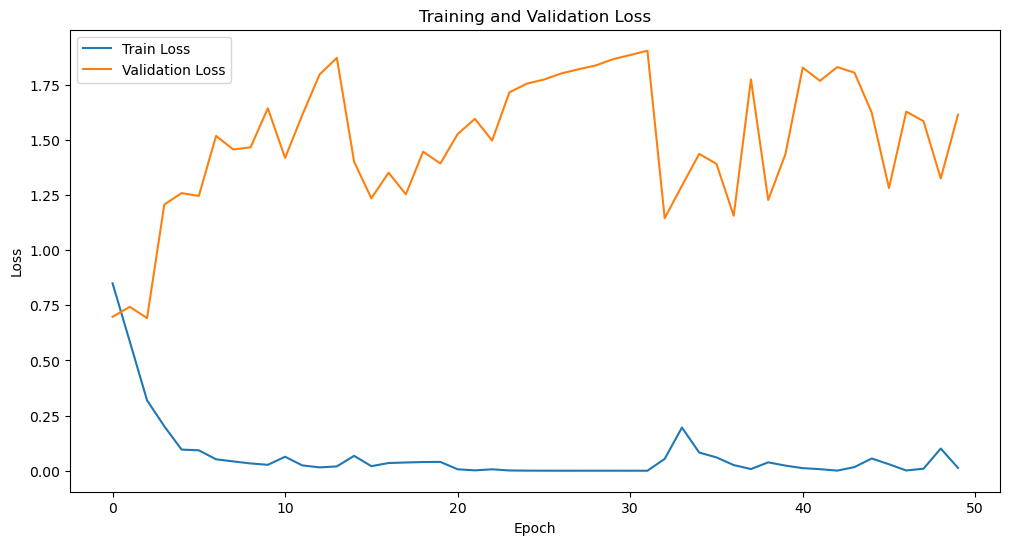

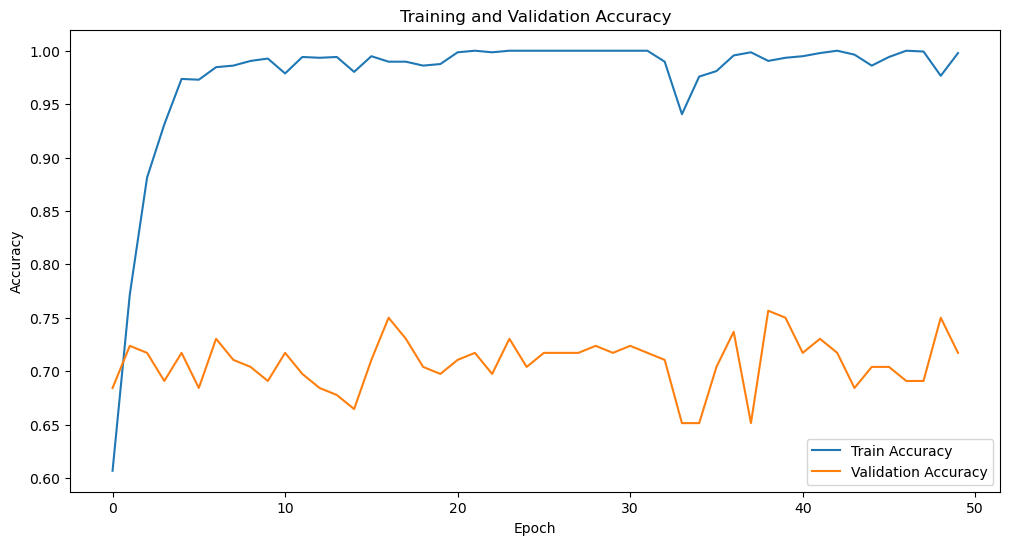

Best validation accuracy: 0.7566


In [16]:
import matplotlib.pyplot as plt
# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

print(f"Best validation accuracy: {best_val_accuracy:.4f}")

In [17]:
# Evaluate on test
model.eval()
torch.set_grad_enabled(False)

total_loss, total_correct, total_labels = 0, 0, 0
list_hyp, list_label = [], []

pbar = tqdm(test_loader, leave=True, total=len(test_loader))
for i, batch_data in enumerate(pbar):
    _, batch_hyp, _ = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')
    list_hyp += batch_hyp

# Save prediction
df = pd.DataFrame({'label':list_hyp}).reset_index()
df.to_csv('pred.txt', index=False)

print(df)

100%|██████████| 8/8 [00:01<00:00,  5.39it/s]


    index    label
0       0  negatif
1       1  negatif
2       2  negatif
3       3  negatif
4       4  positif
..    ...      ...
71     71  negatif
72     72  negatif
73     73  negatif
74     74  negatif
75     75  negatif

[76 rows x 2 columns]


In [18]:
# # Load Tokenizer and Config
# tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-large-p1')
# config = BertConfig.from_pretrained('indobenchmark/indobert-large-p1')
# config.num_labels = DocumentSentimentDataset.NUM_LABELS

# # Instantiate model
# model = BertForSequenceClassification.from_pretrained('indobenchmark/indobert-large-p1', config=config)

# # Muat parameter yang disimpan ke dalam instansiasi model
# model.load_state_dict(torch.load('BERTL905-66-87.pth'))

In [20]:
w2i, i2w = DocumentSentimentDataset.LABEL2INDEX, DocumentSentimentDataset.INDEX2LABEL
print(w2i)
print(i2w)

{'negatif': 0, 'netral': 1, 'positif': 2}
{0: 'negatif', 1: 'netral', 2: 'positif'}


In [25]:
text = ['iklan kudu kencang','Keren bgt produknya','Nanya dong, manfaat program itu apa?']
for t in text:
    subwords = tokenizer.encode(t)
    subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

    logits = model(subwords)[0]
    label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()
    prob = F.softmax(logits, dim=-1).squeeze()[label] * 100
    prob_rounded = round(prob.item(), 2)
    print(f'Teks: {t} | Sentimen : {i2w[label]} ({prob_rounded}%)')
    
    print()

Teks: iklan kudu kencang | Sentimen : negatif (99.97%)

Teks: Keren bgt produknya | Sentimen : positif (99.93%)

Teks: Nanya dong, manfaat program itu apa? | Sentimen : negatif (88.55%)

